# INFO 4907 - EDA Project

Hello, so I decided to do something a bit different. I wanted to expand this assignment a bit and use this dataset for a personal project. As such, my EDA will be focused around the question of "Is this data suitable for training a model?" and, more generally for the visualization part of this assignment "What are the nicknaming habits of Donald Trump?".

Here is my Tableau graph that I created from the work done in this EDA.

<img src="trump_graph.png">

# Donald Trumps Nickname Habits

Hello! In this notebook I will be doing a going through data that I pulled from wikipedia. The data shows the unique nickname given by Donald Trump to various people, groups, and organizations!

+ Which can be found here: https://en.wikipedia.org/wiki/List_of_nicknames_used_by_Donald_Trump

Due to the very short nature of the data, I just copied and pasted it directly from the webpage. However, this means that the data will be very messy and needs to be cleaned. In this notebook I will be doing the following:

+ cleaning the data
+ performing a simple EDA
    - what are the nicknaming habits of Trump?
+ assessing and prepping the data for NLP and a Neural Network

The overarching goal is to create a simple web application using Pheonix and Elixir, and to use a neural framework (TensorFlow, Keras, Torch) to train a model that will generate a Trump Nickname based on the input of a name by the user.

Lets dive into the data!

# What does the data look like?

In [17]:
# packages
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import re

raw = pd.read_csv('trump.nicknames.wikipedia.csv')

# categories I want to keep for visualizations and training
# although all groups might serve better as there is already a low amount of data
people_groups = ['domestic political figures', 'foreign leaders', 'media figures','groups of people', 'other people']

# filter for categories in the list
raw = raw[raw['category'].isin(people_groups)]

raw.head()

,fake,real,notes,category
0,Dumbo[5],Randolph Tex Alles,Director of the United States Secret Service,domestic political figures
1,Where's Hunter[6],Hunter Biden,American lawyer and lobbyist who is the second...,domestic political figures
2,1% Joe[7] / Basement Joe[8] / Beijing Joe[9] /...,Joe Biden,47th vice president of the United States; form...,domestic political figures
3,Little Michael Bloomberg[19] / Mini Mike[20] /...,Michael Bloomberg,108th Mayor of New York City; 2020 Democratic ...,domestic political figures
4,Da Nang Richard[22] / Da Nang Dick[23],Richard Blumenthal,U.S. senator from Connecticut; 23rd attorney g...,domestic political figures


# About the data

A quick blurb about the data:

+ fake = the list of unique nicknames given by Donald Trump
+ real = the real name of the individual, group, or organization
+ notes = descriptions of who the corresponding person is
+ category = the category given by wikipedia

Also, the categories were limited to those that are actual people, and groups of people. As this is going to be used for training a model on nickname generation, this makes the most sense.

# First look

The first thing I notice is that the fake names have reference numbers next to them, and are listed together. So let's create a single row for each fake name, and clean up both fake and real names for any special characters, and bring them to lowercase. We can however leave some characters to see how the model handels them, such as the "1%" nickname given, as it will add context.

# Cleaning the data

In [18]:
# defining two functions,
# get_row() will take information and create a row,
# then clean is used to clean the strings 
def clean(name):
    '''cleans the given name of special chs and lowers'''
    # deletes reference tag and lowers
    name = name[0:name.find('[')].lower()
    # replaces everything but whats in the string with a space
    name = re.sub(r"[^a-z0-9%'.]", " ", name)
    name = re.sub(r"[^a-z0-9% ]", "", name) # replace with null

    if name[0] == ' ': # no leading spaces
        name = name[1:]

    return name

def get_row(fake, row):
    '''takes info and reproduces a row'''
    # pull data from row
    i, f, real, notes, category = row

    return {
        "fake name": clean(fake),
        "real name": str(real).lower(),
        "len fake": len(fake.split(' ')),
        "len real": len(real.split(' ')),
        "category": str(category),
        "notes": str(notes).lower()
    }

# flattening the listed nicknames
cleanDF = pd.DataFrame([get_row(fake, row) # returns dictionary obj
                        for row in raw.itertuples()
                        for fake in str(row[1]).split('/')])

cleanDF.head()
    

,fake name,real name,len fake,len real,category,notes
0,dumbo,randolph tex alles,1,3,domestic political figures,director of the united states secret service
1,wheres hunter,hunter biden,2,2,domestic political figures,american lawyer and lobbyist who is the second...
2,1% joe,joe biden,2,2,domestic political figures,47th vice president of the united states; form...
3,basement joe,joe biden,3,2,domestic political figures,47th vice president of the united states; form...
4,beijing joe,joe biden,3,2,domestic political figures,47th vice president of the united states; form...


As we can see with the head, most special characters are removed, everything is lowercase, and should be ready for training. I also added two columns for the word length of the fake and real names. Let's start by taking a look at the length comparisons.

In the data there are also tags used '(denied by trump)', however these appear after the reference tag, and as such were deleted along with them. However there are a few issues that I hand corrected, first "Ilhan Omar", "Ayanna Pressley", "Rashida Tlaib" had NaN names, as they were originally grouped under one 'person', this was corrected. The name "13/17 Angry Democrats" has a '/' which was also used to seperate the names, so I changed this to another character that will get cleaned into a space. Lastly "Randolph "Tex" Alles" has quotation marks around his name, so I manually cleaned that as his name was the only case of it happening.

One major change is that the data was originally formatted as 'wacky / weirdo / Tom Steyer' effectively changing only the adjective. Instead of attempting to create a set of rules to modify these and since the data is of low volume, I have gone into the data and added the full nickname as given by the sources on wikipedia. Consequently this will raise the word counts for the names in nickname vocabulary, and might effect the output of the generated nickname to include parts of names that are not correlated to the input names. However, that is something that can be dealt with later down the road if it becomes an issue in training.

Now that all the names are cleaned lets move on to some basic statistics of the data.

# Simple Statistics

In [19]:
# printing stats
print(len(cleanDF["fake name"].index), len(cleanDF["real name"].unique()))
print(f'the data shape: {cleanDF.shape}')
print(f'the number of categories: {len(cleanDF["category"].unique())}')
print(f'the number of people that recieved a name: {len(cleanDF["real name"].unique())}')
print(f'the number of Nicknames given by Trump: {len(cleanDF["fake name"].unique())}')
print(f'the number of repeated unique names: {len(cleanDF["fake name"].index) - len(cleanDF["fake name"].unique())}')

173 101
the data shape: (173, 6)
the number of categories: 5
the number of people that recieved a name: 101
the number of Nicknames given by Trump: 167
the number of repeated unique names: 6


Awesome, we can see that there are 167 unique nicknames given by trump, to a total of 101 people. This means that every person recieved ~1.6 unique nicknames.

Lets move onto some visualizations of Trumps Nicknaming Patterns.

# Comparing lengths of nicknames and real names 

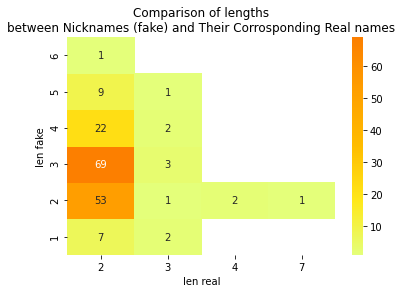

In [33]:
# creating a new column to just rename it easily
cleanDF['count'] = 1
# counting the number of relations between the lengths of words
counts = cleanDF.groupby(['len real', 'len fake']).agg({'count':'count'}).reset_index()

# graphing
ax = sns.heatmap(counts.pivot_table(columns='len real', index='len fake', values='count'), annot=True, cmap='Wistia')
ax.invert_yaxis()
plt.title('Comparison of lengths\nbetween Nicknames (fake) and Their Corrosponding Real names')
plt.show()

Awesome, now we can clearly see the relations between the length of the real names and length of the fake names! We see a trend to add words for real names with less than or equal to 3 words. However, Trumps Nickname word length is typically from 2 - 4 words, with 3 being the most frequent. When generating the names, if we wish to control the number of words in the nicknames, we can use these distributions to create pobabilities for the nickname lengths, based on the user given name!

Next lets dive into our text! Here I want to get a sense of what sort of vocabulary there is to work with



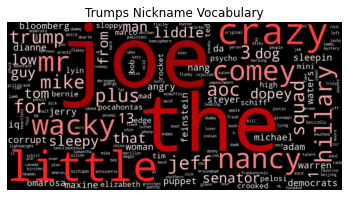

In [31]:
# grabbing the counts of each vocabulary word in the nicknames
fake_counts = (cleanDF['fake name'].str.split(expand=True)
              .stack()
              .value_counts()
              .rename_axis('vals')
              .reset_index(name='count'))

# converting to a dictionary for graphing
words = [word for word in fake_counts['vals']]
n = [n for n in fake_counts['count']]
weights = {words[i]: n[i] for i in range(len(n))}

# custom color function because random coloring is bad
def my_tf_color_func(word, **kwargs):
    w = 6 * weights[word]
    return f"hsl(0, 96%, {110-w}%)"

#graphing
wordcloud = WordCloud(width=1200, height=600, margin=0, relative_scaling=1, color_func=my_tf_color_func)

wordcloud = wordcloud.generate_from_frequencies(weights)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Trumps Nickname Vocabulary')
plt.show()

Here we can see a wordcloud of the fake nicknames coined by trump, with the larger words appearing more frequently in the unique names. I also scaled the color of the words to represent the frequency as well, to make the more frequent words pop out more.

Next I want to look into the count of words per person, to see who the most nicknamed people are! This one is just for fun!

# Who was given the most nicknames?

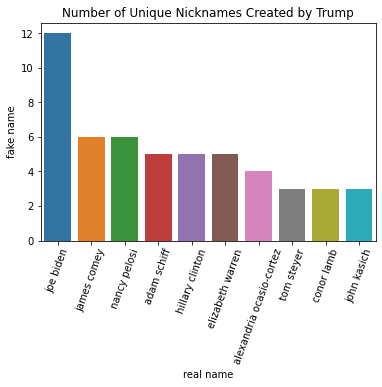

In [30]:
# counting the number of unique names for each real name, then grabbing the top 10
top10 = cleanDF.groupby('real name').agg({'fake name':'count'}).sort_values(by='fake name', ascending=False).reset_index().head(10)

# graphing
ax = sns.barplot(data=top10, x='real name', y='fake name')
plt.xticks(rotation=70)
plt.title('Number of Unique Nicknames Created by Trump')
plt.show()

Here we can see that Joe Biden has, by far, the most nicknames dubbed by Trump. Next up is James Comey, Nancy Pelosi, Adam Schiff, Hillary Clinton, and Elizabeth Warren. Although, do keep in mind this list is strictly the amount of unique names given. I attempted a search for the frequencies of Trump Nicknames, although did not find any easily avaible sources. I gotta say, pretty surprised Hillary Clinton didn't have the most, although I am sure she tops the frequency charts. Also Obama only had 1 coined nickname of "cheatin' Obama"

Now I am going to export the data used to create the python graphs and re-create them in Tableau into a singular visualization.

Most of the nicknames are ironic and seem to be projecting, like "quid pro joe", and there are a few that are just disgusting. None-the-less here is a show list of my favorite from the list.

In [43]:
# some meme programing cause why not
class people:
    def __init__(self, like_list):
        self.i_like = like_list   

    def __str__(self):
        return f'the nicknames i like are: {", ".join(self.i_like)}, ...'

pDF = cleanDF[['fake name', 'real name', 'notes']]
print(p := people('al frankenstein,quid pro joe,mini mike,lyin ted,moderate dog,nervous nancy,britain trump,mad alex,justin from canada,that guy on cbs,jeff bozo'.split(',')))
pDF[pDF['fake name'].isin(p.i_like)].rename(columns={'fake name':'nickname'})

the nicknames i like are: al frankenstein, quid pro joe, mini mike, lyin ted, moderate dog, nervous nancy, britain trump, mad alex, justin from canada, that guy on cbs, jeff bozo, ...


,nickname,real name,notes
8,quid pro joe,joe biden,47th vice president of the united states; form...
15,mini mike,michael bloomberg,108th mayor of new york city; 2020 democratic ...
39,lyin ted,ted cruz,former solicitor general of texas; u.s. senato...
47,al frankenstein,al franken,former u.s. senator from minnesota
61,moderate dog,james mattis,26th secretary of defense
78,nervous nancy,nancy pelosi,speaker of the united states house of represen...
116,britain trump,boris johnson,prime minister of the united kingdom
122,mad alex,alex salmond,former first minister of scotland and scottish...
123,justin from canada,justin trudeau,23rd prime minister of canada
130,that guy on cbs,stephen colbert,host of the late show with stephen colbert; co...


# Is this data good enough for training?

The data seems to be well diverse, with a healthy amount of adjectives. Although there is not a whole lot of nicknames to train from, but luckily as accuracy is not an issue, the whole dataset can be used for training.

One idea of increasing the data size for training is to incorporate synonyms for the adjectives used. As well as some data hallucination techniques to mix the adjectives around to different people. One major note is having the actual names inside the training data, I am hoping this teaches the model to include the user name, however if thats not possible it might be best to just generate the prefix to a name.

Another idea is to use a hand-built algorithm if the neural model does not perform well. Although I am thinking a LSTM character (or word) based generation model will perform well with this data, however there is truly only one way to find out!

In [44]:
# exporting data for tableau visualizations
top10.to_csv('top.10.people.nicknamed.csv', index=False) # bar chart
fake_counts.to_csv('nickname.word.counts.csv', index=False) # wourd frequency
counts.to_csv('heatmap.name.lengths.csv', index=False) # heatmap